In [4]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
df = pd.read_csv("employee_attrition.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               3020 non-null   int64  
 1   Age                      3020 non-null   int64  
 2   Department               3020 non-null   object 
 3   YearsAtCompany           3020 non-null   int64  
 4   YearsInCurrentRole       3020 non-null   int64  
 5   YearsWithCurrentManager  3010 non-null   float64
 6   JobLevel                 3020 non-null   int64  
 7   JobSatisfaction          3006 non-null   float64
 8   Salary                   3007 non-null   float64
 9   Attrition                3020 non-null   object 
 10  WorkLifeBalance          3020 non-null   int64  
 11  OverTime                 3020 non-null   object 
 12  MaritalStatus            3020 non-null   object 
 13  DistanceFromHome         3020 non-null   int64  
 14  Education               

In [7]:
df.head()

,EmployeeID,Age,Department,YearsAtCompany,YearsInCurrentRole,YearsWithCurrentManager,JobLevel,JobSatisfaction,Salary,Attrition,WorkLifeBalance,OverTime,MaritalStatus,DistanceFromHome,Education
0,24,29,Sales,2,11,6.0,2,1.0,69685.0,No,1,No,Divorced,25,College
1,865,28,Sales,22,6,5.0,2,2.0,57823.0,No,2,No,Married,7,College
2,463,27,Engineering,18,6,8.0,5,1.0,118568.0,No,3,Yes,Divorced,37,College
3,868,23,Marketing,20,13,3.0,1,2.0,148336.0,No,1,No,Divorced,33,Bachelor
4,2928,39,HR,25,12,2.0,4,3.0,44332.0,No,4,Yes,Divorced,17,Bachelor


In [8]:
df.shape

(3020, 15)

In [9]:
df.duplicated().sum()

19

##### There are 19 duplicates in the dataset, we'll drop them

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(3001, 15)

In [12]:
df.isnull().sum()

EmployeeID                  0
Age                         0
Department                  0
YearsAtCompany              0
YearsInCurrentRole          0
YearsWithCurrentManager    10
JobLevel                    0
JobSatisfaction            14
Salary                     13
Attrition                   0
WorkLifeBalance             0
OverTime                    0
MaritalStatus               0
DistanceFromHome            0
Education                   0
dtype: int64

##### There are 3 columns with missing values - YearsWithCurrentManager, JobSatisfaction and Salary

## Data Preprocessing

##### Data cleaning

In [13]:
df.columns = df.columns.str.lower()

In [14]:
df.columns

Index(['employeeid', 'age', 'department', 'yearsatcompany',
       'yearsincurrentrole', 'yearswithcurrentmanager', 'joblevel',
       'jobsatisfaction', 'salary', 'attrition', 'worklifebalance', 'overtime',
       'maritalstatus', 'distancefromhome', 'education'],
      dtype='object')

In [15]:
#Get percentage of missing values in each column
round(df.isnull().sum()/len(df) * 100, 2)

employeeid                 0.00
age                        0.00
department                 0.00
yearsatcompany             0.00
yearsincurrentrole         0.00
yearswithcurrentmanager    0.33
joblevel                   0.00
jobsatisfaction            0.47
salary                     0.43
attrition                  0.00
worklifebalance            0.00
overtime                   0.00
maritalstatus              0.00
distancefromhome           0.00
education                  0.00
dtype: float64

##### all columns with missing values are below 0.5% of the total data in each column.

#### Working on the Salary column

In [16]:
#Fill missing values based on various criteria
df["salary"] = df.groupby(["department","joblevel","yearsincurrentrole","education"])["salary"].transform(lambda y: y.fillna(y.median()))

In [17]:
df.salary.isnull().sum()

2

In [18]:
df["salary"] = df.groupby(["department","joblevel","yearsincurrentrole"])["salary"].transform(lambda y: y.fillna(y.median()))

In [19]:
df.salary.isnull().sum()

0

#### Working on the job satisfaction column

In [82]:
#Fill missing values based on various criteria
df["jobsatisfaction"] = df.groupby(["department","joblevel","yearsincurrentrole","education"])["jobsatisfaction"].\
transform(lambda y: y.fillna(y.median()))

In [83]:
df["jobsatisfaction"] = df.groupby(["department","joblevel","yearsincurrentrole"])["jobsatisfaction"].\
transform(lambda y: y.fillna(y.median()))

In [84]:
df["jobsatisfaction"].isnull().sum()

0

<h5>For the yearswithcurrentmanager column, i can't currently think of a fitting way to handle this except for asking a supervisor. Since, the missing values in the column are<br><br> less than 0.5%, i'll drop them. Dropping it affects all other columns on the same row.</h5>

In [85]:
df.dropna(inplace=True)

In [86]:
df["yearswithcurrentmanager"].isna().sum()

0

In [87]:
df.isnull().sum()

employeeid                 0
age                        0
department                 0
yearsatcompany             0
yearsincurrentrole         0
yearswithcurrentmanager    0
joblevel                   0
jobsatisfaction            0
salary                     0
attrition                  0
worklifebalance            0
overtime                   0
maritalstatus              0
distancefromhome           0
education                  0
dtype: int64

#### First phase of feature engineering - creating new features from existing features

##### Tenure-related features

In [88]:
df["roletenureratio"] = df["yearsincurrentrole"]/df["yearsatcompany"]
df["managertenureratio"] = df["yearswithcurrentmanager"]/df["yearsatcompany"]
df["yearsinotherroles"] = df["yearsatcompany"]/df["yearsincurrentrole"]

##### Job level and Salary-related features

In [89]:
salary_by_joblevel = df.groupby("joblevel")["salary"].median()
salary_by_joblevel

joblevel
1    90678.0
2    90340.5
3    93843.0
4    91465.0
5    89992.5
Name: salary, dtype: float64

In [91]:
sal_jl_dict = {}
for i in salary_by_joblevel.index:
    key = i
    value = salary_by_joblevel[i]
    sal_jl_dict[key] = value

In [92]:
sal_jl_dict

{1: 90678.0, 2: 90340.5, 3: 93843.0, 4: 91465.0, 5: 89992.5}

In [93]:
df["salaryperjoblevel"] = df["joblevel"].map(sal_jl_dict)
df["salarytoageratio"] = df["salary"]/df["age"]

##### Satisfaction and work-life balance features

In [94]:
df["satisfactiontosalaryratio"] = df["jobsatisfaction"]/df["salary"]
df["overtime"] = df["overtime"].map({"Yes":1, "No":0})
df["overtimeimpact"] = df["overtime"] * df["jobsatisfaction"]

##### Attrition-related features

In [95]:
df["attrition"] = df["attrition"].map({"Yes":1, "No":0})

In [96]:
df["loyaltyindex"] = df["yearsatcompany"]/df["age"]

##### Department-related features

In [97]:
df["department"].unique()

array(['Sales', 'Engineering', 'Marketing', 'HR', 'Finance'], dtype=object)

In [98]:
df["istechnicaldepartment"] = [1 if dept == "Engineering" else 0 for dept in df["department"]]

In [99]:
salary_by_dept = df.groupby("department")["salary"].median()
salary_by_dept

department
Engineering    89046.0
Finance        91083.0
HR             92605.0
Marketing      90869.5
Sales          88970.5
Name: salary, dtype: float64

In [100]:
dept_dict = {}
for i in salary_by_dept.index:
    key = i
    value = salary_by_dept[i]
    dept_dict[key] = value

In [101]:
dept_dict

{'Engineering': 89046.0,
 'Finance': 91083.0,
 'HR': 92605.0,
 'Marketing': 90869.5,
 'Sales': 88970.5}

In [102]:
df["departmentlevelsalary"] = df["department"].map(dept_dict) 

In [103]:
transformed_df = pd.get_dummies(df, dtype=float, drop_first=True).drop("employeeid", axis=1)

In [104]:
transformed_df.head()

,age,yearsatcompany,yearsincurrentrole,yearswithcurrentmanager,joblevel,jobsatisfaction,salary,attrition,worklifebalance,overtime,...,department_Finance,department_HR,department_Marketing,department_Sales,maritalstatus_Married,maritalstatus_Single,education_Below College,education_College,education_Doctor,education_Master
0,29,2,11,6.0,2,1.0,69685.0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,28,22,6,5.0,2,2.0,57823.0,0,2,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,27,18,6,8.0,5,1.0,118568.0,0,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,20,13,3.0,1,2.0,148336.0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39,25,12,2.0,4,3.0,44332.0,0,4,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


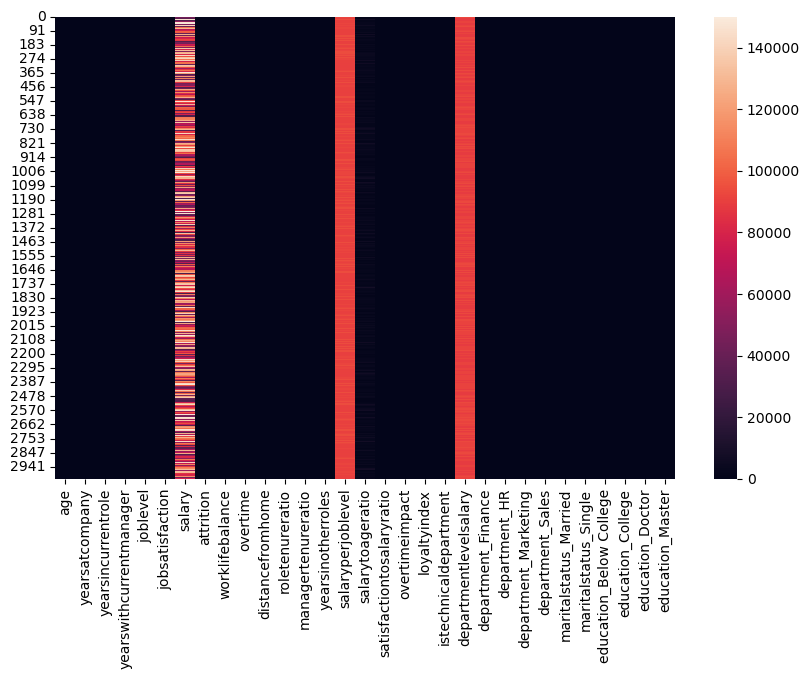

In [105]:
plt.figure(figsize=(10,6))
sns.heatmap(transformed_df);

In [106]:
X = transformed_df[["salary","joblevel","salaryperjoblevel","departmentlevelsalary"]]#.drop("attrition", axis=1)
y = transformed_df["attrition"]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=55)

In [108]:
X_train

,salary,joblevel,salaryperjoblevel,departmentlevelsalary
1444,133578.0,5,89992.5,90869.5
2253,85713.0,5,89992.5,88970.5
1759,137532.0,4,91465.0,90869.5
1038,132755.0,2,90340.5,90869.5
2113,131081.0,5,89992.5,91083.0
...,...,...,...,...
2612,142134.0,5,89992.5,89046.0
972,116923.0,1,90678.0,88970.5
296,90477.0,4,91465.0,88970.5
667,94802.0,5,89992.5,90869.5


## Building and testing accuracy of models

In [109]:
#Instantiating models
lr = LogisticRegression()
dt = DecisionTreeClassifier()
tm = RandomForestClassifier()
gnb = GaussianNB()

In [110]:
models = [lr,dt,tm,gnb]
model_names = ["Logistic Regression", "Decision Tree Classifier", "Random Forest Classifier", "GaussianNB"]

In [111]:
for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    prediction = model.predict(X_train)
    y_pred = model.predict(X_test)
    training_accuracy = accuracy_score(y_train,prediction)
    testing_accuracy = accuracy_score(y_test, y_pred)
    message1 = f"{model_name} training accuracy is {training_accuracy}."
    message2 = f"{model_name} testing accuracy is {testing_accuracy}."
    print(message1)
    print(message2)

Logistic Regression training accuracy is 0.806438127090301.
Logistic Regression testing accuracy is 0.8280467445742905.
Decision Tree Classifier training accuracy is 0.9979096989966555.
Decision Tree Classifier testing accuracy is 0.7295492487479132.
Random Forest Classifier training accuracy is 0.9979096989966555.
Random Forest Classifier testing accuracy is 0.7262103505843072.
GaussianNB training accuracy is 0.806438127090301.
GaussianNB testing accuracy is 0.8280467445742905.


In [112]:
model = lr.fit(X_train,y_train)

prediction = model.predict(X_train)
y_pred = model.predict(X_test)
training_accuracy = accuracy_score(y_train,prediction)
testing_accuracy = accuracy_score(y_test, y_pred)
message1 = f"training accuracy is {training_accuracy}."
message2 = f"testing accuracy is {testing_accuracy}."
print(message1)
print(message2)

training accuracy is 0.806438127090301.
testing accuracy is 0.8280467445742905.


In [113]:
importance = model.coef_[0] 

In [114]:
df = pd.DataFrame({'Feature_name':X.columns, 'Importance':importance})
df1 = df.sort_values(by="Importance", ascending=False)

In [115]:
df1

,Feature_name,Importance
3,departmentlevelsalary,3.167999e-05
0,salary,3.041623e-07
1,joblevel,1.806086e-08
2,salaryperjoblevel,-4.741473e-05


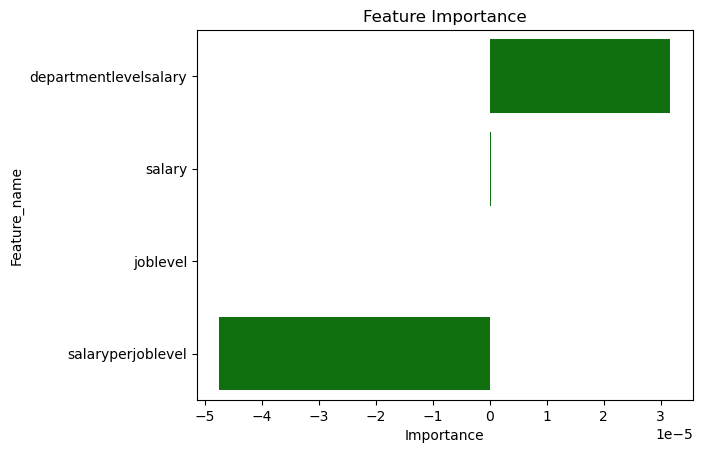

In [116]:
#plt.figure(figsize=(10,7))
sns.barplot(data=df1, y="Feature_name", x="Importance", color='green').set_title("Feature Importance");

In [117]:
import pickle

filename = 'model.pickle'
pickle.dump(model, open(filename, 'wb'))

In [21]:
df["salary"].min()

30014.0

In [22]:
df["salary"].max()

149998.0

In [23]:
df["joblevel"].unique()

array([2, 5, 1, 4, 3], dtype=int64)